#Introduction
CISC 452 Project - Hurricane Trajectory and Intensity Prediction (LSTM)

*   Description: The following code trains a network to predict the next latitude, longtitude, wind pressure, wind speed, and storm direction in 6 hours given the past values from 24 hours (6 hour time intervals). The predictions from the model are then fed back into the model as input, to predict the latitude, longtitude, wind pressure, wind speed and storm direction at 24 hours.


*   Citation: Functions multivariate_data & multi_step_plot are from https://www.tensorflow.org/tutorials/structured_data/time_series?fbclid=IwAR2wmmrcGwp_7n_pBtvJv9yfNYQMiRqHviVCKsSIEgVW8TMHxb9kYHktSsA



By: Ashley Drouillard | 10183354 | 14aad4 | Group 15

In [23]:
!pip install tensorflow-gpu==2.0.0rc numpy tqdm matplotlib --no-cache-dir

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import random as rand
from sklearn import preprocessing

import datetime as dt
import dateutil.parser

from tqdm import tqdm

In [25]:
tf.__version__

'2.0.0-rc0'

#Data Visualization

##Folium
Plots Longtitude and Latitude points on a map

In [0]:
import folium
from folium import IFrame
text = 'actual path'
    
def plot_path_actual(points,pres,map):
    #fadd lines
    folium.PolyLine(points, color="blue", weight=2.5, opacity=1).add_to(map)

def plot_path_predicted(points,pres,map):
    #fadd lines
    folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(map)

def plot_path_history(points,pres,map):
    #fadd lines
    folium.PolyLine(points, color="black", weight=2.5, opacity=1).add_to(map)
    

## Multi Step Plot
Function to plot history, predicted, and actual points on a graph.

In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps
  
def multi_step_plot(history, true_future, prediction, title=None):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.title(title)
  plt.show()

# Dataset Processing



*   Load data from csv
*   Filter out bad data (ensure timestamps are 6 hour intervals apart, remove storms that don't contain enough data/missing data)


*   Normalize the data





In [28]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Import the raw IBtracs hurricane data stored on GitHub
url = 'https://raw.githubusercontent.com/emma-howard/hurricane-project/master/Dataset/NA_basin.csv'
data = pd.read_csv(url, header=0)

data = pd.read_csv(data_file)
Season = (data.SEASON > 1980)
df = data[Season]

df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,WMO_AGENCY,TRACK_TYPE,DIST2LAND,LANDFALL,IFLAG,USA_AGENCY,USA_ATCF_ID,USA_LAT,USA_LON,USA_RECORD,USA_STATUS,USA_WIND,USA_PRES,USA_SSHS,STORM_SPEED,STORM_DIR
3933,1981127N18276,1981,35,NaN,CS,ARLENE,1981-05-06 18:00,TS,18.4,-83.6,30,1006,hurdat_atl,main,300,300,O_____________,hurdat_atl,AL031981,18.4,-83.6,,TD,30,1006,-1,8,92
3934,1981127N18276,1981,35,NaN,CS,ARLENE,1981-05-07 0:00,TS,18.4,-82.7,30,1006,hurdat_atl,main,335,328,O_____________,hurdat_atl,AL031981,18.4,-82.7,,TD,30,1006,-1,9,85
3935,1981127N18276,1981,35,NaN,CS,ARLENE,1981-05-07 6:00,TS,18.6,-81.7,30,1005,hurdat_atl,main,333,300,O_____________,hurdat_atl,AL031981,18.6,-81.7,,TD,30,1005,-1,11,74
3936,1981127N18276,1981,35,NaN,CS,ARLENE,1981-05-07 12:00,TS,19.0,-80.6,35,1003,hurdat_atl,main,248,219,O_____________,hurdat_atl,AL031981,19.0,-80.6,,TS,35,1003,0,11,62
3937,1981127N18276,1981,35,NaN,CS,ARLENE,1981-05-07 18:00,TS,19.6,-79.7,40,1000,hurdat_atl,main,199,148,O_____________,hurdat_atl,AL031981,19.6,-79.7,,TS,40,1000,0,11,53


In [29]:
# Sort Storms by Storm ID (SID)
hurricane_SID = []
for i in range(1, len(df)):
  if (df.iloc[i].SID not in hurricane_SID):
    hurricane_SID.append(df.iloc[i].SID)

print(hurricane_SID)
print(len(hurricane_SID))

['1981127N18276', '1981181N36295', '1981215N36292', '1981219N11334', '1981244N30287', '1981247N16300', '1981250N15306', '1981255N14311', '1981265N14328', '1981303N25313', '1981307N17279', '1981317N31286', '1982154N22273', '1982169N26274', '1982241N14338', '1982252N26269', '1982257N20291', '1982274N25295', '1983228N27270', '1983236N26284', '1983254N30296', '1983270N28287', '1984231N33295', '1984242N11309', '1984244N13319', '1984244N37293', '1984253N29283', '1984258N20264', '1984260N14339', '1984261N29295', '1984267N31302', '1984270N23287', '1984281N24291', '1984311N15291', '1984348N35300', '1985197N29296', '1985202N26275', '1985222N32280', '1985224N18279', '1985240N20286', '1985259N24289', '1985260N13336', '1985265N30286', '1985280N18291', '1985299N25270', '1985320N21296', '1986156N26284', '1986175N26273', '1986226N30276', '1986250N11308', '1986254N22309', '1986323N23297', '1987220N34283', '1987222N26266', '1987230N15340', '1987249N15329', '1987252N11342', '1987263N10309', '1987282N1527

In [0]:
def CleanStorm(interval,storm):
  toRemove = []
  lastCleanTime = dateutil.parser.parse(storm['ISO_TIME'].iloc[0])
  # check if the last correct time minus the current time is in the correct interval
  for i in range(1,len(storm)):
    nextTime = dateutil.parser.parse(storm['ISO_TIME'].iloc[i])
    tDelta = nextTime - lastCleanTime
    if tDelta == interval:
      lastCleanTime = nextTime
    else:
      toRemove.append(storm.iloc[i])

  # Remove the bad data
  storm = storm.set_index("ISO_TIME")
  for r in toRemove:
    storm.drop(r['ISO_TIME'], axis=0)
    #df.drop(r['ISO_TIME'], axis=0)
  return storm


In [31]:
# Clean storms
hurricane_SID_remove = []

for i in range(0, len(hurricane_SID)):
  hurricanes = []

  # Columns to filter
  filter_SID = (df.SID.str.strip() == hurricane_SID[i])
  filtered_data = df[filter_SID]

  filtered_data = CleanStorm(6, filtered_data)
  if (len(filtered_data) < 8):
    hurricane_SID_remove.append(hurricane_SID[i])

for storm in hurricane_SID_remove:
  hurricane_SID.remove(storm)

print(len(hurricane_SID))

504


In [32]:
# First first 80% of the rows rows of the data will be 
# the training dataset, and there remaining will be the validation dataset.
TRAIN_SPLIT = int(len(hurricane_SID) * 0.8)

# Setting seed to ensure reproducibility.
tf.random.set_seed(13)

print(TRAIN_SPLIT)

403


In [33]:
features_considered = ['LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'STORM_DIR']

features = df[features_considered]
features.index = df['ISO_TIME']

features.head()

,LAT,LON,WMO_WIND,WMO_PRES,STORM_DIR
ISO_TIME,,,,,
1981-05-06 18:00,18.4,-83.6,30,1006,92
1981-05-07 0:00,18.4,-82.7,30,1006,85
1981-05-07 6:00,18.6,-81.7,30,1005,74
1981-05-07 12:00,19.0,-80.6,35,1003,62
1981-05-07 18:00,19.6,-79.7,40,1000,53


#Training and Testing Data

In [0]:
# Normalize Data
dataset = features.values

data_min = dataset.min(axis=0)
data_max = dataset.max(axis=0)

dataset = (dataset-data_min)/(data_max-data_min)

In [0]:
def retreiveDatasetByName(sid, ds, ds_values):
  filtered_ds_values = []
  for i in range(len(ds)):
    if (ds.iloc[i].SID == sid):
      filtered_ds_values.append(ds_values[i])
  return np.array(filtered_ds_values)

In [0]:
# Create list of data for each storm
hurricanes_by_SID = []
j = 0
for sid in hurricane_SID:
  hurricane = retreiveDatasetByName(sid, df, dataset)
  hurricanes_by_SID.append(hurricane)
  j += 1

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return data, labels 

In [0]:
future_target = 1
past_history = 4
STEP = 1

def setUpTrainingAndTestingData(start_index, end_index, feature):

  x_train = []
  y_train = []

  for i in range(start_index, end_index):
    hurricane_data = hurricanes_by_SID[i]

    x, y = multivariate_data(hurricane_data, hurricane_data[:,feature],
                                                      0, None,
                                                      past_history, future_target,
                                                      STEP)
    x_train = x_train + x
    y_train = y_train + y
  
  return np.array(x_train), np.array(y_train)


In [0]:
lat_index = 0
lon_index = 1
wind_index = 2
pres_index = 3
dir_index = 4

# Latitude
x_train_lat, y_train_lat = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = lat_index)
x_val_lat, y_val_lat = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), lat_index)

# Longtitude
x_train_lon, y_train_lon = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = lon_index)
x_val_lon, y_val_lon = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), lon_index)

# Wind Speed
x_train_wind, y_train_wind = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = wind_index)
x_val_wind, y_val_wind = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), wind_index)

# Wind Pressure
x_train_pres, y_train_pres = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = pres_index)
x_val_pres, y_val_pres = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), pres_index)

# Direction
x_train_dir, y_train_dir = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = dir_index)
x_val_dir, y_val_dir = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), dir_index)

Let's check out a sample data-point.

In [40]:
print ('Single window of past history : {}'.format(x_train_lat[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_lat[0].shape))

Single window of past history : (4, 5)

 Target temperature to predict : (1,)


In [0]:
BATCH_SIZE = 32

# Latitude
train_data_lat = tf.data.Dataset.from_tensor_slices((x_train_lat, y_train_lat))
train_data_lat = train_data_lat.cache().batch(BATCH_SIZE).repeat()

val_data_lat = tf.data.Dataset.from_tensor_slices((x_val_lat, y_val_lat))
val_data_lat = val_data_lat.batch(BATCH_SIZE).repeat()

# Longtitude
train_data_lon = tf.data.Dataset.from_tensor_slices((x_train_lon, y_train_lon))
train_data_lon = train_data_lon.cache().batch(BATCH_SIZE).repeat()

val_data_lon = tf.data.Dataset.from_tensor_slices((x_val_lon, y_val_lon))
val_data_lon = val_data_lon.batch(BATCH_SIZE).repeat()

# Wind Speed
train_data_wind = tf.data.Dataset.from_tensor_slices((x_train_wind, y_train_wind))
train_data_wind = train_data_wind.cache().batch(BATCH_SIZE).repeat()

val_data_wind = tf.data.Dataset.from_tensor_slices((x_val_wind, y_val_wind))
val_data_wind = val_data_wind.batch(BATCH_SIZE).repeat()

# Wind Pressure
train_data_pres = tf.data.Dataset.from_tensor_slices((x_train_pres, y_train_pres))
train_data_pres = train_data_pres.cache().batch(BATCH_SIZE).repeat()

val_data_pres = tf.data.Dataset.from_tensor_slices((x_val_pres, y_val_pres))
val_data_pres = val_data_pres.batch(BATCH_SIZE).repeat()

# Wind Direction
train_data_dir = tf.data.Dataset.from_tensor_slices((x_train_dir, y_train_dir))
train_data_dir = train_data_dir.cache().batch(BATCH_SIZE).repeat()

val_data_dir = tf.data.Dataset.from_tensor_slices((x_val_dir, y_val_dir))
val_data_dir = val_data_dir.batch(BATCH_SIZE).repeat()

# Models
There are 5 models. One for each output: Latitude, Longtitude, Wind Speed, Wind Pressure, Direction.

## Latitude

In [0]:
model_lat = tf.keras.models.Sequential()
model_lat.add(tf.keras.layers.LSTM(32, return_sequences=True,
                                       input_shape=x_train_lat.shape[-2:]))
model_lat.add(tf.keras.layers.LSTM(16, activation="relu"))
model_lat.add(tf.keras.layers.Dense(future_target))

model_lat.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=["mae", "mse"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 32)             4864      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 8,017
Trainable params: 8,017
Non-trainable params: 0
_________________________________________________________________
None


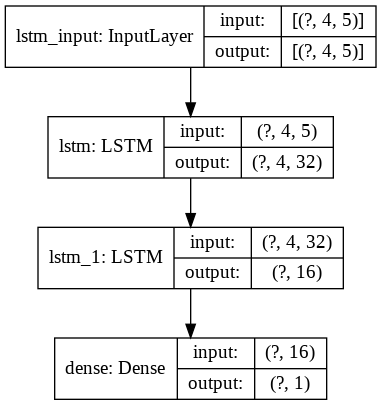

In [43]:
print(model_lat.summary())
tf.keras.utils.plot_model(model_lat, to_file='my_model.png', show_shapes=True, show_layer_names=True)

##Logtitude

In [0]:
model_lon = tf.keras.models.Sequential()
model_lon.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_lon.shape[-2:]))
model_lon.add(tf.keras.layers.LSTM(16, activation="relu"))
model_lon.add(tf.keras.layers.Dense(future_target))

model_lon.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=["mae", "mse"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4, 32)             4864      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 8,017
Trainable params: 8,017
Non-trainable params: 0
_________________________________________________________________
None


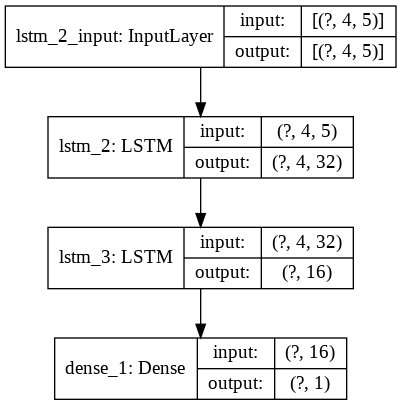

In [45]:
print(model_lon.summary())
tf.keras.utils.plot_model(model_lon, to_file='my_model.png', show_shapes=True, show_layer_names=True)

## Wind Speed

In [0]:
model_wind = tf.keras.models.Sequential()
model_wind.add(tf.keras.layers.LSTM(32, return_sequences=True,
                                       input_shape=x_train_lat.shape[-2:]))
model_wind.add(tf.keras.layers.LSTM(16, activation="relu"))
model_wind.add(tf.keras.layers.Dense(future_target))

model_wind.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=["mae", "mse"])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4, 32)             4864      
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 8,017
Trainable params: 8,017
Non-trainable params: 0
_________________________________________________________________
None


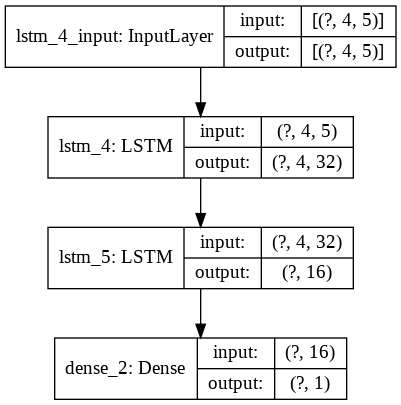

In [47]:
print(model_wind.summary())
tf.keras.utils.plot_model(model_wind, to_file='my_model.png', show_shapes=True, show_layer_names=True)

## Wind Pressure

In [0]:
model_pres = tf.keras.models.Sequential()
model_pres.add(tf.keras.layers.LSTM(32, return_sequences=True,
                                       input_shape=x_train_pres.shape[-2:]))
model_pres.add(tf.keras.layers.LSTM(16, activation="relu"))
model_pres.add(tf.keras.layers.Dense(future_target))

model_pres.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=["mae", "mse"])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 4, 32)             4864      
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 8,017
Trainable params: 8,017
Non-trainable params: 0
_________________________________________________________________
None


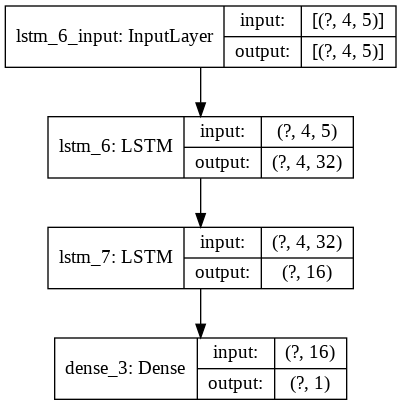

In [49]:
print(model_pres.summary())
tf.keras.utils.plot_model(model_pres, to_file='my_model.png', show_shapes=True, show_layer_names=True)

## Direction

In [0]:
model_dir = tf.keras.models.Sequential()
model_dir.add(tf.keras.layers.LSTM(32, return_sequences=True,
                                       input_shape=x_train_dir.shape[-2:]))
model_dir.add(tf.keras.layers.LSTM(16, activation="relu"))
model_dir.add(tf.keras.layers.Dense(future_target))

model_dir.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=["mae", "mse"])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 4, 32)             4864      
_________________________________________________________________
lstm_9 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 8,017
Trainable params: 8,017
Non-trainable params: 0
_________________________________________________________________
None


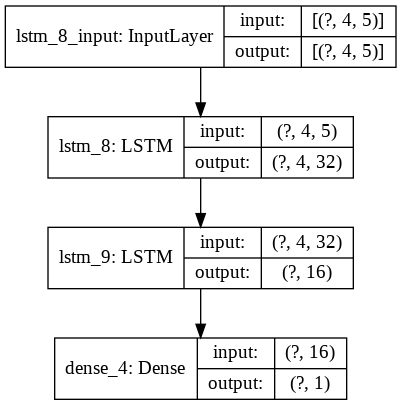

In [51]:
print(model_dir.summary())
tf.keras.utils.plot_model(model_dir, to_file='my_model.png', show_shapes=True, show_layer_names=True)

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

# Training

## Parameters

In [0]:
EPOCH_STEPS = TRAIN_SPLIT
VAL_STEPS = len(hurricane_SID) - TRAIN_SPLIT
EPOCHS = 100
PATIENCE = 10 

## Latitude

In [54]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Set callback functions to early stop training and save the best model so far
callbacks_lat = [EarlyStopping(monitor='val_loss', patience=PATIENCE),
              ModelCheckpoint(filepath='best_model_lat.h5', monitor='val_loss', save_best_only=True)]

multi_step_history = model_lat.fit(train_data_lat, epochs=EPOCHS, 
                                   steps_per_epoch=EPOCH_STEPS,
                                   validation_steps=VAL_STEPS,
                                  validation_data=val_data_lat,
                                   callbacks=callbacks_lat)

Using TensorFlow backend.


Train for 403 steps, validate for 101 steps
Epoch 1/100
403/403 [==============================] - 12s 31ms/step - loss: 0.0652 - mae: 0.0653 - mse: 0.0105 - val_loss: 0.0228 - val_mae: 0.0228 - val_mse: 8.7630e-04
Epoch 2/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0236 - mae: 0.0236 - mse: 9.6040e-04 - val_loss: 0.0190 - val_mae: 0.0190 - val_mse: 6.7280e-04
Epoch 3/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0203 - mae: 0.0203 - mse: 7.4226e-04 - val_loss: 0.0193 - val_mae: 0.0193 - val_mse: 6.2674e-04
Epoch 4/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0193 - mae: 0.0193 - mse: 6.7331e-04 - val_loss: 0.0161 - val_mae: 0.0161 - val_mse: 4.7462e-04
Epoch 5/100
403/403 [==============================] - 6s 15ms/step - loss: 0.0170 - mae: 0.0170 - mse: 5.3579e-04 - val_loss: 0.0155 - val_mae: 0.0155 - val_mse: 5.2612e-04
Epoch 6/100
403/403 [==============================] - 6s 15ms/step - loss: 0.0164 - mae:

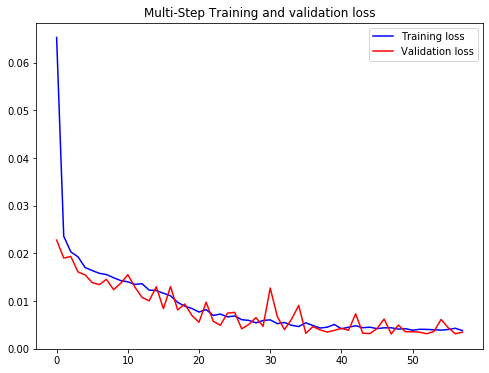

In [55]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

## Longtitude

In [56]:
# Set# Set callback functions to early stop training and save the best model so far
callbacks_lon = [EarlyStopping(monitor='val_loss', patience=PATIENCE),
              ModelCheckpoint(filepath='best_model_lon.h5', monitor='val_loss', save_best_only=True)]

multi_step_history = model_lon.fit(train_data_lon, epochs=EPOCHS,
                                   steps_per_epoch=EPOCH_STEPS,
                                   validation_steps=VAL_STEPS,
                                   validation_data=val_data_lon,
                                   callbacks=callbacks_lon)

Train for 403 steps, validate for 101 steps
Epoch 1/100
403/403 [==============================] - 9s 23ms/step - loss: 0.0592 - mae: 0.0593 - mse: 0.0096 - val_loss: 0.0200 - val_mae: 0.0199 - val_mse: 6.0073e-04
Epoch 2/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0170 - mae: 0.0170 - mse: 5.1246e-04 - val_loss: 0.0130 - val_mae: 0.0130 - val_mse: 3.3273e-04
Epoch 3/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0158 - mae: 0.0158 - mse: 4.4710e-04 - val_loss: 0.0122 - val_mae: 0.0122 - val_mse: 3.1359e-04
Epoch 4/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0148 - mae: 0.0149 - mse: 4.0559e-04 - val_loss: 0.0126 - val_mae: 0.0126 - val_mse: 3.4378e-04
Epoch 5/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0145 - mae: 0.0145 - mse: 3.9053e-04 - val_loss: 0.0130 - val_mae: 0.0130 - val_mse: 3.2468e-04
Epoch 6/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0147 - mae: 

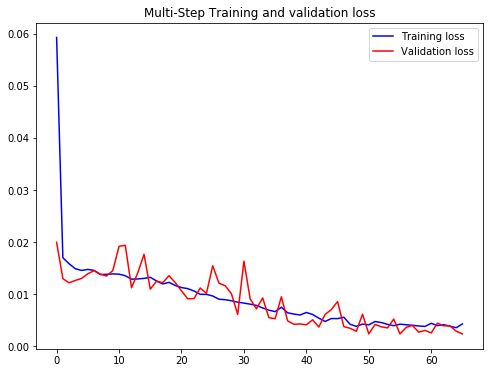

In [57]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

Predict a multi-step future: 
Let's now have a look at how well your network has learnt to predict the future.

## Wind Speed

In [58]:
# Set callback functions to early stop training and save the best model so far
callbacks_wind = [EarlyStopping(monitor='val_loss', patience=PATIENCE),
              ModelCheckpoint(filepath='best_model_wind.h5', monitor='val_loss', save_best_only=True)]

multi_step_history = model_wind.fit(train_data_wind, epochs=EPOCHS,
                                    steps_per_epoch=EPOCH_STEPS,
                                    validation_steps=VAL_STEPS,
                                    validation_data=val_data_wind,
                                    callbacks=callbacks_wind)

Train for 403 steps, validate for 101 steps
Epoch 1/100
403/403 [==============================] - 9s 23ms/step - loss: 0.0798 - mae: 0.0800 - mse: 0.0135 - val_loss: 0.0478 - val_mae: 0.0478 - val_mse: 0.0044
Epoch 2/100
403/403 [==============================] - 6s 15ms/step - loss: 0.0518 - mae: 0.0519 - mse: 0.0051 - val_loss: 0.0408 - val_mae: 0.0408 - val_mse: 0.0032
Epoch 3/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0428 - mae: 0.0428 - mse: 0.0035 - val_loss: 0.0407 - val_mae: 0.0407 - val_mse: 0.0033
Epoch 4/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0321 - mae: 0.0321 - mse: 0.0021 - val_loss: 0.0239 - val_mae: 0.0239 - val_mse: 0.0011
Epoch 5/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0266 - mae: 0.0266 - mse: 0.0015 - val_loss: 0.0204 - val_mae: 0.0204 - val_mse: 8.9472e-04
Epoch 6/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0249 - mae: 0.0250 - mse: 0.0013 - val_loss:

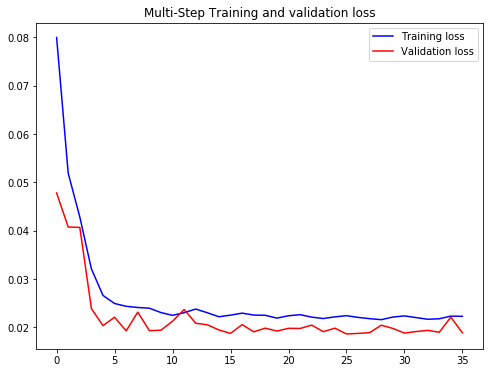

In [59]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

## Wind Pressure

In [60]:
# Set callback functions to early stop training and save the best model so far
# Set callback functions to early stop training and save the best model so far
callbacks_pres = [EarlyStopping(monitor='val_loss', patience=PATIENCE),
              ModelCheckpoint(filepath='best_model_pres.h5', monitor='val_loss', save_best_only=True)]

multi_step_history = model_pres.fit(train_data_pres, epochs=EPOCHS,
                                    steps_per_epoch=EPOCH_STEPS,
                                    validation_steps=VAL_STEPS,
                                    validation_data=val_data_pres,
                                    callbacks=callbacks_pres)

Train for 403 steps, validate for 101 steps
Epoch 1/100
403/403 [==============================] - 9s 23ms/step - loss: 0.1040 - mae: 0.1042 - mse: 0.0390 - val_loss: 0.0347 - val_mae: 0.0347 - val_mse: 0.0025
Epoch 2/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0403 - mae: 0.0404 - mse: 0.0032 - val_loss: 0.0332 - val_mae: 0.0332 - val_mse: 0.0024
Epoch 3/100
403/403 [==============================] - 6s 15ms/step - loss: 0.0385 - mae: 0.0386 - mse: 0.0030 - val_loss: 0.0333 - val_mae: 0.0333 - val_mse: 0.0023
Epoch 4/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0368 - mae: 0.0369 - mse: 0.0029 - val_loss: 0.0290 - val_mae: 0.0290 - val_mse: 0.0019
Epoch 5/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0339 - mae: 0.0340 - mse: 0.0023 - val_loss: 0.0293 - val_mae: 0.0292 - val_mse: 0.0016
Epoch 6/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0289 - mae: 0.0290 - mse: 0.0017 - val_loss: 0.0

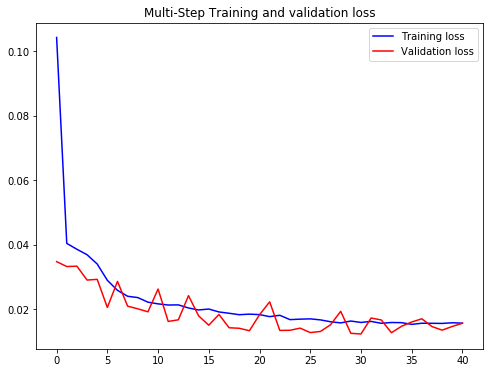

In [61]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

## Direction

In [62]:
# Set callback functions to early stop training and save the best model so far
callbacks_dir = [EarlyStopping(monitor='val_loss', patience=PATIENCE),
              ModelCheckpoint(filepath='best_model_dir.h5', monitor='val_loss', save_best_only=True)]

multi_step_history = model_dir.fit(train_data_dir, epochs=100,
                                   steps_per_epoch=EPOCH_STEPS,
                                   validation_steps=VAL_STEPS,
                                    validation_data=val_data_dir,
                                   callbacks=callbacks_dir)

Train for 403 steps, validate for 101 steps
Epoch 1/100
403/403 [==============================] - 9s 23ms/step - loss: 0.1890 - mae: 0.1892 - mse: 0.0875 - val_loss: 0.1332 - val_mae: 0.1333 - val_mse: 0.0594
Epoch 2/100
403/403 [==============================] - 6s 14ms/step - loss: 0.1308 - mae: 0.1310 - mse: 0.0576 - val_loss: 0.1183 - val_mae: 0.1184 - val_mse: 0.0524
Epoch 3/100
403/403 [==============================] - 6s 14ms/step - loss: 0.1062 - mae: 0.1063 - mse: 0.0468 - val_loss: 0.0851 - val_mae: 0.0851 - val_mse: 0.0383
Epoch 4/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0823 - mae: 0.0823 - mse: 0.0405 - val_loss: 0.0698 - val_mae: 0.0699 - val_mse: 0.0377
Epoch 5/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0769 - mae: 0.0771 - mse: 0.0418 - val_loss: 0.0851 - val_mae: 0.0851 - val_mse: 0.0380
Epoch 6/100
403/403 [==============================] - 6s 14ms/step - loss: 0.0767 - mae: 0.0768 - mse: 0.0417 - val_loss: 0.0

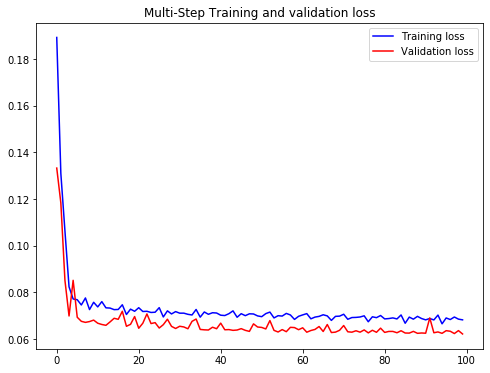

In [63]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

# Testing Network: 24h Trajectory and Intensity Prediction
Test network and plot paths on a map for a given storm.

In [0]:
lat_min = data_min[0]
lat_max = data_max[0]
lon_min = data_min[1]
lon_max = data_max[1]


def tensor_to_array(tensor1):
    return tensor1.numpy()

def un_normalize_lon_lat(lat, lon):
  new_lat = (lat * (lat_max-lat_min)) + lat_min
  new_lon = (lon * (lon_max-lon_min)) + lon_min
  return new_lat, new_lon

def tuple_to_lists(list_tuples):
  list0 = []
  list1 = []
  for x,y in list_tuples:
    list0.append(x)
    list1.append(y)
  return list0, list1

In [0]:
best_model_lat = tf.keras.models.load_model('best_model_lat.h5')
best_model_lon =  tf.keras.models.load_model('best_model_lon.h5')
best_model_wind =  tf.keras.models.load_model('best_model_wind.h5')
best_model_pres =  tf.keras.models.load_model('best_model_pres.h5')
best_model_dir =  tf.keras.models.load_model('best_model_dir.h5')

def get_24hstorm_prediction(storm):
  history = []
  expected = []
  actual = []
  
  history_pres = []
  expected_pres = []
  actual_pres = []

  for i in range(0,4):
    history.append(un_normalize_lon_lat(storm[i][0], storm[i][1]))
    history_pres.append(storm[i][3])

  input_x = np.array(storm[0:4])

  for i in range(4,8):

    x = input_x.reshape(1, input_x.shape[0], input_x.shape[1])
    output_y = np.array(storm[i+1])
    y = output_y.reshape(1, output_y.shape[0], 1)

    predicted_lat = best_model_lat.predict(x)
    predicted_lon = best_model_lon.predict(x)
    predicted_wind = best_model_wind.predict(x)
    predicted_pres = best_model_pres.predict(x)
    predicted_dir = best_model_dir.predict(x)

    predicted = [float(predicted_lat), float(predicted_lon), float(predicted_wind), float(predicted_pres), float(predicted_dir)]
    
    expected.append(un_normalize_lon_lat(storm[i][0], storm[i][1]))
    actual.append(un_normalize_lon_lat(predicted[0], predicted[1]))
    expected_pres.append(storm[i][3])
    actual_pres.append(predicted[3])

    new_input = []
    for j in range(i-3,i):
      new_input.append(storm[j])
    new_input.append(predicted)
    input_x = np.array(new_input)

  return history, actual, expected, history_pres, actual_pres, expected_pres

In [0]:
STEP = 1

def plot_hurricane_prediction_map(i):
  name = hurricane_SID[i]
  storm = retreiveDatasetByName(name, df, dataset)

  history, actual, expected, history_pres, actual_pres, expected_pres = get_24hstorm_prediction(storm)
  actual = [history[-1]] + actual
  expected = [history[-1]] + expected
  history_lat, history_lon = tuple_to_lists(history)
  actual_lat, actual_lon = tuple_to_lists(actual)
  expected_lat, expected_lon = tuple_to_lists(expected)

  history_lat = np.array(history_lat)
  history_lon = np.array(history_lon)

  actual_lat = np.array(actual_lat)
  actual_lon = np.array(actual_lon)

  expected_lat = np.array(expected_lat)
  expected_lon = np.array(expected_lon)

  multi_step_plot(history_lat, expected_lat[1:], actual_lat[0:-1], name+" Latitude")
  multi_step_plot(history_lon, expected_lon[1:], actual_lon[0:-1], name+" Longtitude")
  multi_step_plot(np.array(history_pres), np.array(expected_pres), np.array(actual_pres), name+" Wind Pressure")

  ave_lat = sum(p[0] for p in actual)/len(actual)
  ave_lon = sum(p[1] for p in actual)/len(actual)

  # Load map centred on average coordinates
  my_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=8)

  plot_path_actual(actual,actual_pres, my_map)
  plot_path_predicted(expected, expected_pres, my_map)
  plot_path_history(history, history_pres, my_map)

  # Save map
  map_str = "./map-" + name + ".html"
  my_map.save(map_str)

  display(my_map)

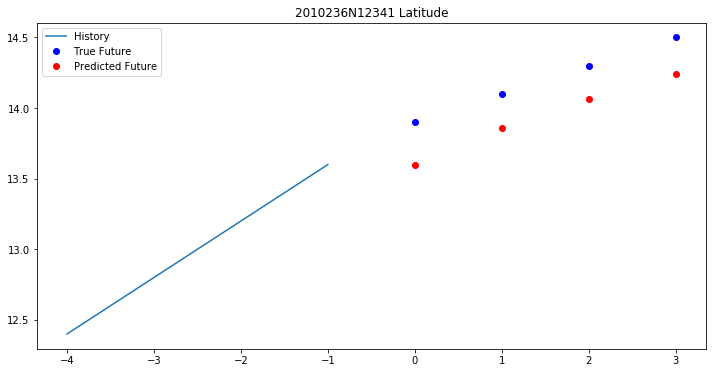

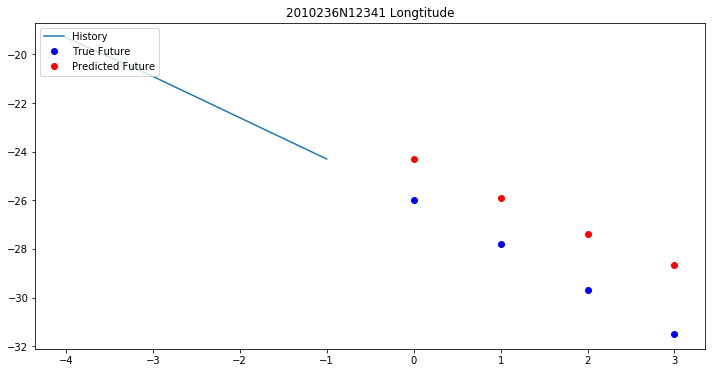

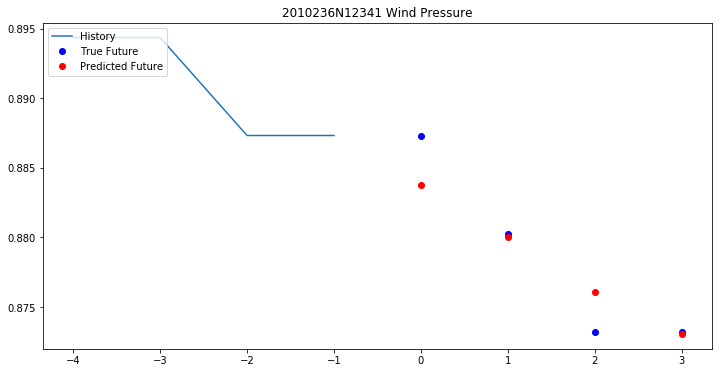

In [77]:
plot_hurricane_prediction_map(367)

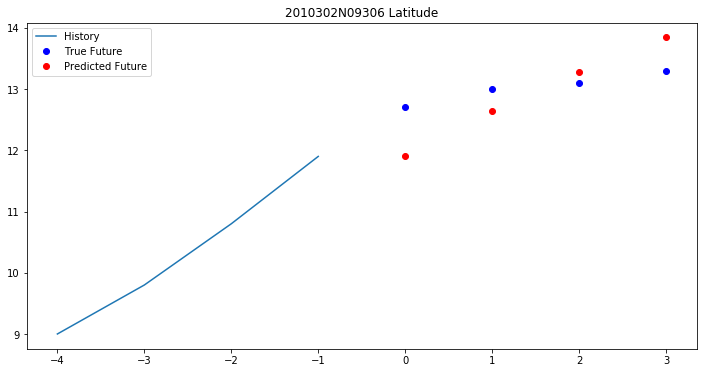

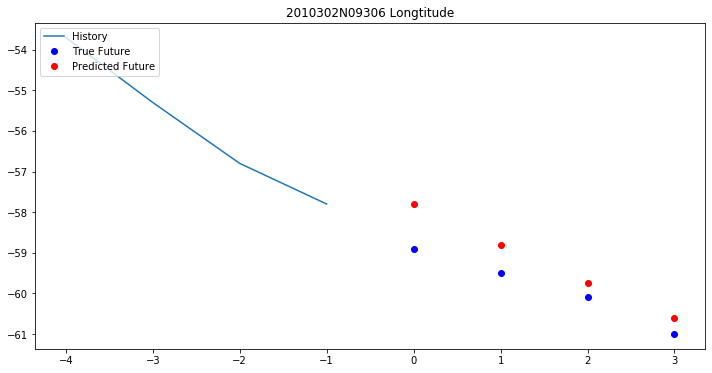

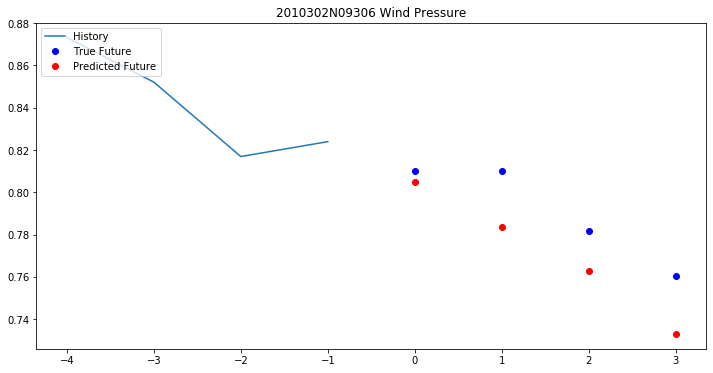

In [76]:
plot_hurricane_prediction_map(380)

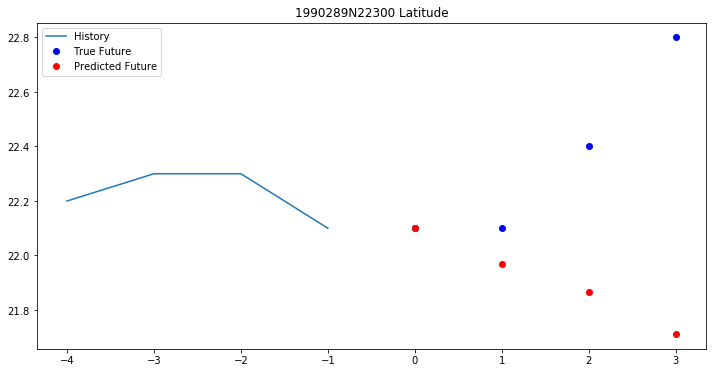

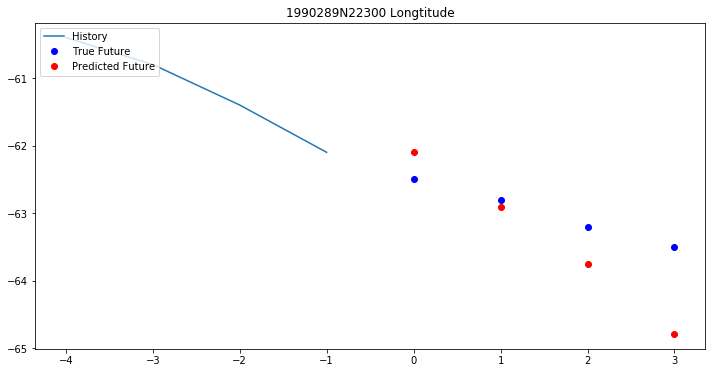

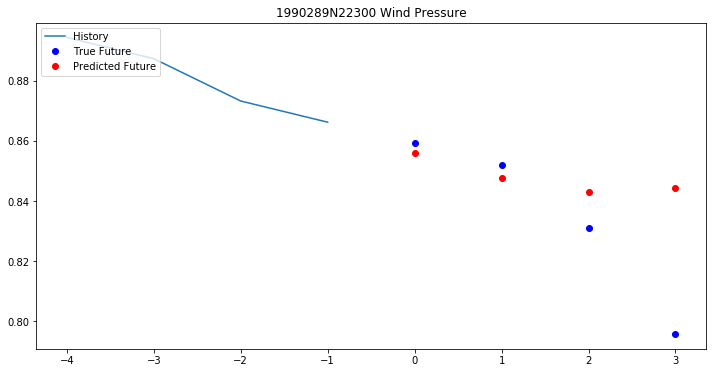

In [75]:
plot_hurricane_prediction_map(94)